In [12]:
# Block 1: Install & Imports
!pip install torch torchvision scikit-learn pandas numpy matplotlib tqdm

import os, sys
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision.models as models
import torchvision.transforms as transforms

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [13]:
# Block 2: Mount Drive (Colab) and set dataset path
from google.colab import drive
drive.mount('/content/drive')

DATASET_PATH = input("/content/drive/MyDrive/urop_dataset").strip()
TRAIN_DIR = os.path.join(DATASET_PATH, "Training")
TEST_DIR  = os.path.join(DATASET_PATH, "Testing")

print("Train dir exists:", os.path.isdir(TRAIN_DIR))
print("Test dir exists:", os.path.isdir(TEST_DIR))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/urop_dataset/content/drive/MyDrive/urop_dataset
Train dir exists: True
Test dir exists: True


In [14]:
# Block 3: Median filter + AlexNet feature extraction
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

alexnet.classifier = torch.nn.Sequential(*list(alexnet.classifier.children())[:-1])
alexnet.eval().to(device)

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

import cv2

def median_filter_image(img_pil, ksize=3):
    arr = np.array(img_pil.convert("L"))
    filtered = cv2.medianBlur(arr, ksize)
    return Image.fromarray(filtered).convert("RGB")

def extract_features_from_folder(folder_path):
    X, y = [], []
    for label in sorted(os.listdir(folder_path)):
        class_dir = os.path.join(folder_path, label)
        if not os.path.isdir(class_dir): continue
        for fname in tqdm(sorted(os.listdir(class_dir)), desc=f"Feat {label}"):
            path = os.path.join(class_dir, fname)
            try:
                img = Image.open(path)
                img = median_filter_image(img, ksize=3)
                t = transform(img).unsqueeze(0).to(device)
                with torch.no_grad():
                    feats = alexnet(t).cpu().numpy().flatten()
                X.append(feats)
                y.append(label)
            except Exception as e:
                print("WARN", path, e)
    return np.array(X), np.array(y)

print("Extract training features...")
X_train, y_train = extract_features_from_folder(TRAIN_DIR)
print("Extract testing features...")
X_test, y_test = extract_features_from_folder(TEST_DIR)

print("Shapes:", X_train.shape, X_test.shape)


Extract training features...


Feat pituitary: 100%|██████████| 1457/1457 [01:19<00:00, 18.24it/s]


Extract testing features...


Feat pituitary: 100%|██████████| 300/300 [00:16<00:00, 17.99it/s]

Shapes: (5713, 4096) (1311, 4096)


In [15]:
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca  = pca.transform(X_test)
print("PCA reduced to:", X_train_pca.shape[1], "components")

# MinMax to make features non-negative (chi2 requirement)
mms = MinMaxScaler(feature_range=(0, 1))
X_train_nonneg = mms.fit_transform(X_train_pca)
X_test_nonneg  = mms.transform(X_test_pca)

# Chi-square selection (top k)
k = 150
k = min(k, X_train_nonneg.shape[1])
chi2sel = SelectKBest(score_func=chi2, k=k)
X_train_sel = chi2sel.fit_transform(X_train_nonneg, LabelEncoder().fit_transform(y_train))
X_test_sel  = chi2sel.transform(X_test_nonneg)

print("After chi2 selection shape:", X_train_sel.shape)


PCA reduced to: 294 components
After chi2 selection shape: (5713, 150)


In [16]:
# Block 5: Label encoding and final standard scaling
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_sel)
X_test_final  = scaler.transform(X_test_sel)

print("Final shapes:", X_train_final.shape, X_test_final.shape)
print("Classes:", le.classes_)


Final shapes: (5713, 150) (1311, 150)
Classes: ['glioma' 'meningioma' 'notumor' 'pituitary']


In [17]:
# Block 6A: SVM (RBF)
svm = SVC(kernel='rbf', C=1, probability=True, random_state=42)
svm.fit(X_train_final, y_train_enc)
pred_svm = svm.predict(X_test_final)

cm = confusion_matrix(y_test_enc, pred_svm)
TP = np.diag(cm); FP = cm.sum(axis=0)-TP; FN = cm.sum(axis=1)-TP; TN = cm.sum()- (TP+FP+FN)

acc_svm = accuracy_score(y_test_enc, pred_svm)
sen_svm = np.mean(TP / (TP + FN))
spe_svm = np.mean(TN / (TN + FP))
pre_svm = precision_score(y_test_enc, pred_svm, average='macro')
rec_svm = recall_score(y_test_enc, pred_svm, average='macro')

print("SVM Results")
print("Accuracy:", acc_svm)
print("Sensitivity (mean):", sen_svm)
print("Specificity (mean):", spe_svm)
print("Precision (macro):", pre_svm)
print("Recall (macro):", rec_svm)


SVM Results
Accuracy: 0.9527078565980168
Sensitivity (mean): 0.948562091503268
Specificity (mean): 0.9845206655816365
Precision (macro): 0.9515976253266483
Recall (macro): 0.948562091503268


In [18]:
# Block 6B: KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_final, y_train_enc)
pred_knn = knn.predict(X_test_final)

cm = confusion_matrix(y_test_enc, pred_knn)
TP = np.diag(cm); FP = cm.sum(axis=0)-TP; FN = cm.sum(axis=1)-TP; TN = cm.sum()- (TP+FP+FN)

acc_knn = accuracy_score(y_test_enc, pred_knn)
sen_knn = np.mean(TP / (TP + FN))
spe_knn = np.mean(TN / (TN + FP))
pre_knn = precision_score(y_test_enc, pred_knn, average='macro')
rec_knn = recall_score(y_test_enc, pred_knn, average='macro')

print("KNN Results")
print("Accuracy:", acc_knn)
print("Sensitivity (mean):", sen_knn)
print("Specificity (mean):", spe_knn)
print("Precision (macro):", pre_knn)
print("Recall (macro):", rec_knn)


KNN Results
Accuracy: 0.9061784897025171
Sensitivity (mean): 0.9025526506899056
Specificity (mean): 0.9690853096906648
Precision (macro): 0.9009747898703837
Recall (macro): 0.9025526506899056


In [19]:
# Block 6C: Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_final, y_train_enc)
pred_rf = rf.predict(X_test_final)

cm = confusion_matrix(y_test_enc, pred_rf)
TP = np.diag(cm); FP = cm.sum(axis=0)-TP; FN = cm.sum(axis=1)-TP; TN = cm.sum()- (TP+FP+FN)

acc_rf = accuracy_score(y_test_enc, pred_rf)
sen_rf = np.mean(TP / (TP + FN))
spe_rf = np.mean(TN / (TN + FP))
pre_rf = precision_score(y_test_enc, pred_rf, average='macro')
rec_rf = recall_score(y_test_enc, pred_rf, average='macro')

print("Random Forest Results")
print("Accuracy:", acc_rf)
print("Sensitivity (mean):", sen_rf)
print("Specificity (mean):", spe_rf)
print("Precision (macro):", pre_rf)
print("Recall (macro):", rec_rf)


Random Forest Results
Accuracy: 0.9252479023646072
Sensitivity (mean): 0.9188598402323893
Specificity (mean): 0.975527317037545
Precision (macro): 0.9269071367836321
Recall (macro): 0.9188598402323893


In [20]:
# Block 6D: Naive Bayes
nb = GaussianNB()
nb.fit(X_train_final, y_train_enc)
pred_nb = nb.predict(X_test_final)

cm = confusion_matrix(y_test_enc, pred_nb)
TP = np.diag(cm); FP = cm.sum(axis=0)-TP; FN = cm.sum(axis=1)-TP; TN = cm.sum()- (TP+FP+FN)

acc_nb = accuracy_score(y_test_enc, pred_nb)
sen_nb = np.mean(TP / (TP + FN))
spe_nb = np.mean(TN / (TN + FP))
pre_nb = precision_score(y_test_enc, pred_nb, average='macro')
rec_nb = recall_score(y_test_enc, pred_nb, average='macro')

print("Naive Bayes Results")
print("Accuracy:", acc_nb)
print("Sensitivity (mean):", sen_nb)
print("Specificity (mean):", spe_nb)
print("Precision (macro):", pre_nb)
print("Recall (macro):", rec_nb)


Naive Bayes Results
Accuracy: 0.6948893974065599
Sensitivity (mean): 0.6923456790123457
Specificity (mean): 0.8970348871712341
Precision (macro): 0.6880931674678302
Recall (macro): 0.6923456790123457



Performance Summary:

      Classifier  Accuracy  Sensitivity  Specificity  Precision  Recall
0            SVM    0.9527       0.9486       0.9845     0.9516  0.9486
1            KNN    0.9062       0.9026       0.9691     0.9010  0.9026
2  Random Forest    0.9252       0.9189       0.9755     0.9269  0.9189
3    Naive Bayes    0.6949       0.6923       0.8970     0.6881  0.6923

Best classifier by Accuracy: SVM (95.27%)


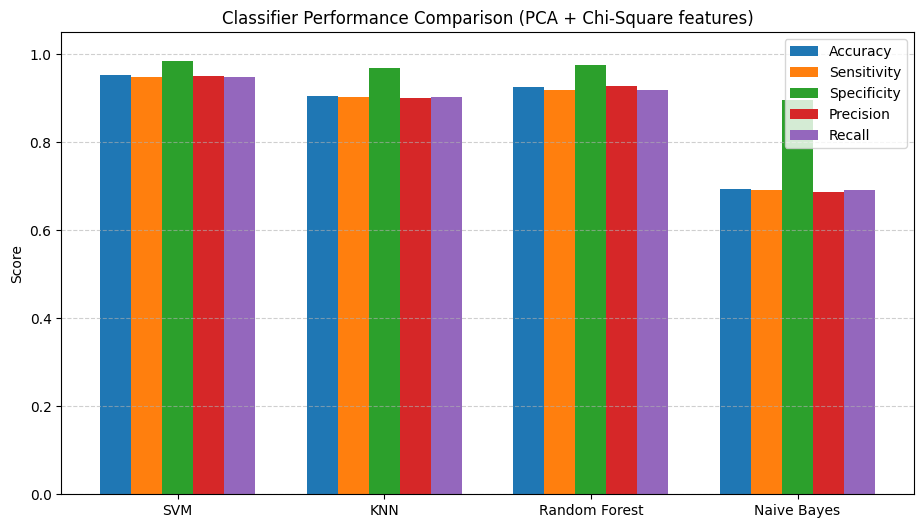

In [21]:
# Block 7: Summary & Bar Graph
models = ['SVM', 'KNN', 'Random Forest', 'Naive Bayes']
accuracy    = [acc_svm, acc_knn, acc_rf, acc_nb]
sensitivity = [sen_svm, sen_knn, sen_rf, sen_nb]
specificity = [spe_svm, spe_knn, spe_rf, spe_nb]
precision   = [pre_svm, pre_knn, pre_rf, pre_nb]
recall      = [rec_svm, rec_knn, rec_rf, rec_nb]

results_df = pd.DataFrame({
    'Classifier': models,
    'Accuracy': accuracy,
    'Sensitivity': sensitivity,
    'Specificity': specificity,
    'Precision': precision,
    'Recall': recall
}).round(4)

print("\nPerformance Summary:\n")
print(results_df)

best_idx = np.nanargmax(accuracy)
best_model = models[best_idx]
best_acc = accuracy[best_idx]
print(f"\nBest classifier by Accuracy: {best_model} ({best_acc*100:.2f}%)")

# Bar graph
bar_width = 0.15
x = np.arange(len(models))
plt.figure(figsize=(11,6))
plt.bar(x - 2*bar_width, accuracy, width=bar_width, label='Accuracy')
plt.bar(x - bar_width, sensitivity, width=bar_width, label='Sensitivity')
plt.bar(x, specificity, width=bar_width, label='Specificity')
plt.bar(x + bar_width, precision, width=bar_width, label='Precision')
plt.bar(x + 2*bar_width, recall, width=bar_width, label='Recall')

plt.xticks(x, models)
plt.ylim(0,1.05)
plt.ylabel('Score')
plt.title('Classifier Performance Comparison (PCA + Chi-Square features)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()